# Display objects/screens in the object list

In [32]:
import bigpemu_debug as bigp
import struct

"""
Code starts 0x00192000
"""
locations = {
    # The address to start at
    # The number of bytes to fetch
    "ddlist":     (0xEF9A,8),
    "activeobjects":     (0x847C,8),
}

def send_hex_dump_cmd_raw(from_addr,dump_len,responses=1):
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\xff\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,responses)
    return response[0][2][24:] # Snip header

def send_hex_dump_cmd(location):
    from_addr,dump_len = locations[location]
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\xff\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,1)
    return response[0][2][24:] # Snip header

def dump_standard(hex_dump,WIDTH=32):
    mem = '\n'.join([
        ','.join(['{:02X}'.format(x) for x in hex_dump[l:l+WIDTH]]) 
        for l in range(0,len(hex_dump),WIDTH)
    ])
    return mem



## Launch BigPEmu and connect to the debug server

Get BigPEmu.

In [ ]:
!wget https://www.richwhitehouse.com/jaguar/builds/BigPEmu_v118-DEV.zip
!unzip -d BigPEmu_v118-DEV BigPEmu_v118-DEV.zip

Run Tempest 2000 using BigPEmu.

In [79]:
import socket
import os
import time

# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../tempest2k/t2000.abs &")
time.sleep(5)

HOST = "127.0.0.1"  # The server's hostname or IP address
PORT = 44123  # The port used by the server

# Connect to the debug server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((HOST, PORT))


## Get the Object List

In [ ]:
# Extract the bits for each entry in the object.
get_bits = lambda o,start,end: (o >> start) & int('1' * ((end-start)+1),base=2)
def get_type(o): return get_bits(o,0,2)

def getPixels(cry_pixels,width=2):
    rgb_pixels = []
    for i in range(0, len(cry_pixels),2):
        t = cry_pixels[i:i+2]
        #print(i,t,int.from_bytes(t,'little'))
        rgb = cry.cry_to_rgb(int.from_bytes(t,'big'))
        rgb_pixels += [rgb]
    pad_len = width - (len(rgb_pixels) % width)
    rgb_pixels += [(0,0,0)] * pad_len # Pad to our chosen width
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels

def get1BitPixels(cry_pixels,width=2):
    rgb_pixels = []
    for b in cry_pixels:
        for m in [128,64,32,16,8,4,2,1]:
            rgb_pixels += [(255,255,255) if (b & m) else (0,0,0)]
    pad_len = width - (len(rgb_pixels) % width)
    rgb_pixels += [(0,0,0)] * pad_len
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels


In [115]:
import cry_rgb as cry
from PIL import Image, ImageColor
import numpy as np
import matplotlib.pyplot as plt

run_vex = [
"rrts","player_shot","run_flipper","run_zap","kill_shot","run_tanker",
"run_spike","run_spiker","run_ashot","run_fuseball","blowaway",
"run_pulsar","oblow","go_downc","go_downf","claw_con2","claw_con1",
"rez_claw","czoom1","czoom2","pzap","rundroid",
"run_pixex","run_pspark","run_prex","run_pup","xshot","run_gate",
"xr_pixex","run_fw","run_h2hclaw","run_mirr","run_h2hshot","run_h2hgen",
"run_h2hball","oblow2","rumirr","refsht","refsht2","run_adroid","loiter"
]
def get_run_vex(x):
    i = int.from_bytes(x, byteorder='big', signed=False)
    if i > len(run_vex):
        return x.hex()
    return run_vex[i]

draw_vex = [
"rrts","draw","draw_z","draw_vxc","draw_spike","draw_pixex","draw_mpixex",
"draw_oneup","draw_pel","changex",
"draw_pring","draw_prex","dxshot","drawsphere","draw_fw","dmpix","dsclaw","dsclaw2"
]
def get_draw_vex(x):
    i = int.from_bytes(x, byteorder='big', signed=False)
    if i > len(draw_vex):
        return x.hex()
    return draw_vex[i]

solids = [
"rrts","cdraw_sflipper","draw_sfliptank","s_shot","draw_sfuseball",
"draw_spulsar","draw_sfusetank","ringbull","draw_spulstank",
"draw_pixex","draw_pup1","draw_gate","draw_h2hclaw","draw_mirr",
"draw_h2hshot","draw_h2hgen","dxshot",
"draw_pprex","draw_h2hball","draw_blueflip","ringbull","supf1",
"supf2","draw_beast","dr_beast3","dr_beast2","draw_adroid"
]
def get_draw_routine(x):
    index = int.from_bytes(x,byteorder='big',signed=True)
    if index < 0:
        # It's an index into 'solids'
        return solids[abs(index)]
    # It's the address of a vector object.
    return x.hex()

rail_type = [
    "climb rail",
    "cross rail",
    "blowaway"
]

enemy_type = [
    "not an enemy",
    "enemy",
]

active_object_def = [ # First Phrase
    (0,3  ,"Index into draw routine in 'solids'.", get_draw_routine),
    (4,7  ,"X", None),
    (8,11 ,"Y", None),
    (12,15,"Z", None),
    (16,19,"Position/lane on web.", None),
    (20,23,"Velocity", None),
    (24,27,"Acceleration/Flipper Mode", None),
    (28,29,"XZ Orientation  (Roll)", None),
    (30,31,"Y Rotation  (Pitch)", None),
    (32,33,"Z Rotation  (Yaw)", None),
    (34,35,"Draw Type (Index into draw routine in draw_vex)",get_draw_vex),
    (36,39,"Start address of pixel data.", None),
    (40,41,"Colour", None),
    (42,43,"Scale factor", None),
    (44,45,"0 = climb rail, 1 = cross rail, 2 = blowaway", None),
    (46,49,"Size of Pixel Data", None),
    (50,51,"Marked for deletion", None),
    (52,53,"0 = not an enemy, 1 = enemy, ,1 = vulnerable", None),
    (54,55,"Object Type  (Index into update routine in run_vex).", get_run_vex),
    (56,59,"Address of Previous Object", None),
    (60,63,"Address of Next Object", None),
]


In [125]:
# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../tempest2k/t2000.abs &")
time.sleep(5)
# Connect to the debug server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((HOST, PORT))


Get the current object list, print it out and store a copy so we can use it to retrieve the screen data.

In [ ]:
import binascii

def get_pixel_data(data_adr,data_len):
    data = bytearray()
    while len(data) < data_len:
        data += send_hex_dump_cmd_raw(data_adr,0xF000)
        data_adr += 0xF000
    data = data[:data_len]
    return data

# Get the address of the object list.
hex_dump = send_hex_dump_cmd("activeobjects")
ao_addr = int.from_bytes(hex_dump[:4], byteorder='big', signed=False)
print(hex(ao_addr))

NUM_OBJECTS = 32
OBJECT_LENGTH = 64
active_object_data = send_hex_dump_cmd_raw(ao_addr,NUM_OBJECTS*OBJECT_LENGTH)
#print(active_object_data)



In [118]:
hex_dump

bytearray(b'\x00\x00\xccx\x00\x00\xcc8')

In [123]:
def lookup_value(lookup, o_val):
    if not lookup:
        return o_val.hex()
    return lookup(o_val)

curr_address = int.from_bytes(hex_dump[:4], byteorder='big', signed=False)
active_objects = []
for ao_index in range(0, NUM_OBJECTS*OBJECT_LENGTH, OBJECT_LENGTH):
    o_data = active_object_data[ao_index:ao_index+OBJECT_LENGTH]
    o_vals_print = []
    for start,end,description, lookup in active_object_def:
        o_val = o_data[start:end+1]
        lookup_val = lookup_value(lookup, o_val)
        o_vals_print += [(description, lookup_val)]
    o_vals_print += [("Current Address", hex(curr_address))]
    curr_address += OBJECT_LENGTH
    active_objects +=[o_vals_print]
    
active_objects



[[("Index into draw routine in 'solids'.", 'draw_pixex'),
  ('X', '00080000'),
  ('Y', '00060000'),
  ('Z', '00288000'),
  ('Position/lane on web.', '00070000'),
  ('Velocity', '00010000'),
  ('Acceleration/Flipper Mode', '0000ca82'),
  ('XZ Orientation  (Roll)', '0018'),
  ('Y Rotation  (Pitch)', '0000'),
  ('Z Rotation  (Yaw)', '0000'),
  ('Draw Type (Index into draw routine in draw_vex)', 'draw_pixex'),
  ('Start address of pixel data.', '00b6000a'),
  ('Colour', '0018'),
  ('Scale factor', '0001'),
  ('0 = climb rail, 1 = cross rail, 2 = blowaway', '0000'),
  ('Size of Pixel Data', '00070007'),
  ('Marked for deletion', '0000'),
  ('0 = not an enemy, 1 = enemy, ,1 = vulnerable', '0000'),
  ('Object Type  (Index into update routine in run_vex).', 'player_shot'),
  ('Address of Previous Object', 'ffffffff'),
  ('Address of Next Object', '0000ccb8'),
  ('Current Address', '0xcc78')],
 [("Index into draw routine in 'solids'.", 'draw_pixex'),
  ('X', '000e0000'),
  ('Y', '00000000'),
  

In [74]:
active_objects[9]

[("Index into draw routine in 'solids'.", 'ffffffff'),
 ('X', '00080000'),
 ('Y', '00080000'),
 ('Z', '006cec00'),
 ('Position/lane on web.', '0006ec00'),
 ('Velocity', '000400e0'),
 ('Acceleration/Flipper Mode', '00000808'),
 ('XZ Orientation  (Roll)', 'ffe0'),
 ('Y Rotation  (Pitch)', '0000'),
 ('Z Rotation  (Yaw)', '0000'),
 ('Draw Type (Index into draw routine in draw_vex)', '000b'),
 ('Start address of pixel data.', '0000ffff'),
 ('Colour', '00f0'),
 ('Scale factor', '0001'),
 ('0 = climb rail, 1 = cross rail, 2 = blowaway', '0026'),
 ('Size of Pixel Data', '00100000'),
 ('Marked for deletion', '0000'),
 ('0 = not an enemy, 1 = enemy, ,1 = vulnerable', '0001'),
 ('Object Type  (Index into update routine in run_vex).', '0018'),
 ('Address of Previous Object', '0000cf78'),
 ('Address of Next Object', '0000cd38')]

In [72]:
active_object_pixels = []
for ao in active_objects:
    start_address = int(ao[11][1],16)
    data_len = min(0xffff,int(ao[15][1],16))
    print(start_address,data_len)
    pixel_data = get_pixel_data(start_address,data_len)
    active_object_pixels += [pixel_data]
active_object_pixels[0]

bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

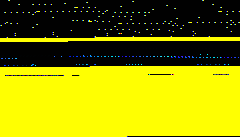

In [76]:
SCALE = 1
data =active_object_pixels[9]
pixels = getPixels(data,240)
img = Image.fromarray(pixels,mode='RGB')
img = img.resize((img.width * SCALE, img.height * SCALE), Image.NEAREST)
img

## Display the objects in the object list

Let's examine the screen data in each of our objects!

384 279 214272
384 279 214272


<Figure size 504x504 with 0 Axes>

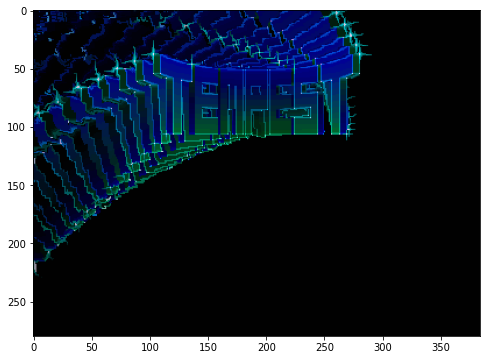

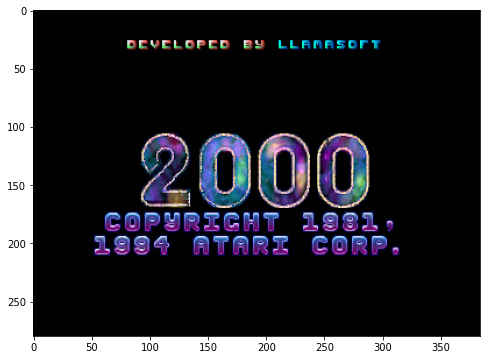

In [5]:
SCALE = 1
pixels_for_depth = [get1BitPixels,get1BitPixels,get1BitPixels,get1BitPixels,
                    getPixels,getPixels]

fig = plt.figure(figsize=(7,7))

def clip_data(data, data_width, clip_width, data_len):
    clipped_data = bytearray()
    for i in range(0,len(data), data_width):
        clipped_data += data[i:i+clip_width]
        if len(clipped_data) > data_len:
            break
    return clipped_data

for i, o in enumerate(obj_list_data):
    if o["Type"] < 2:
        clip_width = o["IWIDTH"] * 8
        data_width = o["DWIDTH"] * 8
        image_height = o["HEIGHT"] 
        image_width = o["IWIDTH"] * 4
        if not image_width:
            continue
        data_len = (image_width * 2) * image_height
        print(image_width, image_height, data_len)
        data = o["DATA_BYTES"]
        data = clip_data(data, data_width, clip_width, data_len)
        
        get_pixels = pixels_for_depth[o["DEPTH"]]
        pixels = get_pixels(data,image_width)
        
        img = Image.fromarray(pixels,mode='RGB')
        img = img.resize((img.width * SCALE, img.height * SCALE), Image.NEAREST)
        img.save(f"object_list/data_{i}_raw.png")
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.savefig(f"object_list/data_{i}.png", transparent=True,bbox_inches='tight')
        continue



 ## Get the Blitter Flags and Data

In [1]:
import socket
import os
import time
# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../tempest2k/t2000.abs &")
time.sleep(5)


In [1]:
import socket
import fcntl,os
import time

# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../tempest2k/t2000.abs &")
time.sleep(5)

HOST = "127.0.0.1"  # The server's hostname or IP address
PORT = 44123  # The port used by the server

# Connect to the debug server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((HOST, PORT))
fcntl.fcntl(s, fcntl.F_SETFL, os.O_NONBLOCK)

0

In [2]:
import bigpemu_debug as bigp
import struct

"""
Set a breakpoint in 'scar' in antelope.gas at f035e4.
"""
breakpoint = b"\x11\x00\x00\x00\x30\x00\x00\x00\xff\x00\x00\x00\x00\x00\x00\x00" \
            b"\x01\x00\x00\x00\x00\x00\x00\x00\xe4\x35\xf0\x00\x00\x00\x00\x00" \
            b"\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00" \
            b"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00"

s.sendall(breakpoint)
response = bigp.get_response(s,3)
response

BlockingIOError: [Errno 11] Resource temporarily unavailable

In [55]:
resume = b"\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00"
s.sendall(resume)
response = bigp.get_response(s,5)
response

BlockingIOError: [Errno 11] Resource temporarily unavailable

In [60]:
response = bigp.get_response(s,5)
response

BlockingIOError: [Errno 11] Resource temporarily unavailable

In [58]:
removeall = b"\x11\x00\x00\x00\x08\x00\x00\x00\xff\x00\x00\x00\x00\x00\x00\x00" \
            b"\x00\x00\x00\x00\x00\x00\x00\x00"
s.sendall(removeall)

In [ ]:
"\x0c\x00\x00\x00\x10\x00\x00\x00\x37\x00\x00\x00\x00\x00\x00\x00" \
"\x60\x3f\xf0\x00\x00\x00\x00\x00\x20\x02\x00\x00\x00\x00\x00\x00"

"\x0c\x00\x00\x00\x10\x00\x00\x00\x3a\x00\x00\x00\x00\x00\x00\x00" \
"\x70\x3f\xf0\x00\x00\x00\x00\x00\x20\x02\x00\x00\x00\x00\x00\x00"

"\x0c\x00\x00\x00\x10\x00\x00\x00\x3b\x00\x00\x00\x00\x00\x00\x00" \
"\x60\x3f\xf0\x00\x00\x00\x00\x00\x20\x02\x00\x00\x00\x00\x00\x00"

"\x0c\x00\x00\x00\x10\x00\x00\x00\x33\x00\x00\x00\x00\x00\x00\x00" \
"\x60\x3f\xf0\x00\x00\x00\x00\x00\x3c\x00\x00\x00\x00\x00\x00\x00"

"\x0c\x00\x00\x00\x10\x00\x00\x00\x16\x00\x00\x00\x00\x00\x00\x00" \
"\xd4\xc3\x80\x00\x00\x00\x00\x00\x20\x02\x00\x00\x00\x00\x00\x00"

"\x0c\x00\x00\x00\x10\x00\x00\x00\x17\x00\x00\x00\x00\x00\x00\x00" \
"\xd0\xc3\x80\x00\x00\x00\x00\x00\x20\x02\x00\x00\x00\x00\x00\x00"

"\x0c\x00\x00\x00\x10\x00\x00\x00\x19\x00\x00\x00\x00\x00\x00\x00" \
"\xd8\xc3\x80\x00\x00\x00\x00\x00\x20\x02\x00\x00\x00\x00\x00\x00"


In [5]:
import struct

def send_hex_dump_cmd_raw2(from_addr,dump_len):
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)
    send_hex_dump_cmd_raw2.counter += 1
    counter = struct.pack('<H', send_hex_dump_cmd_raw2.counter)
    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00" + counter +  b"\x00\x00\x00\x00\x00\x00" \
    + from_addr +   b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,1)
    return response[0][2][24:] # Snip header
send_hex_dump_cmd_raw2.counter = 0x10

In [12]:
gpu_addr = 0x80c3d4
hex_dump = send_hex_dump_cmd_raw(gpu_addr,0x10)
print(dump_standard(hex_dump,WIDTH=4))


BlockingIOError: [Errno 11] Resource temporarily unavailable

In [ ]:

s.recv(40)

###### gpu_addr = 0xF03F60
hex_dump = send_hex_dump_cmd_raw(gpu_addr,0x3c)
print(dump_standard(hex_dump,WIDTH=4))


In [88]:
from_addr = 0xF02200
dump_len = 0x3c
from_addr = struct.pack('<I', from_addr)
dump_len = struct.pack('<H', dump_len)

hex_dump = \
b"\x0c\x00\x00\x00\x10\x00\x00\x00\x15\x00\x00\x00\x00\x00\x00\x00" \
+ from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

s.sendall(hex_dump)
response = bigp.get_response(s,1)
print(response)



[(bytearray(b'\x07\x00\x00\x00T\x00\x00\x00K\x00\x00\x00\x00\x00\x00\x00'), 84, bytearray(b'\x15\x00\x00\x00\x00\x00\x00\x00`?\xf0\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x01\x80\x00\x00\x00\xf0\x00\x00\x01\xf4\x00\x00\x01\xf4\x00\x00\x00\xff\x00\xc0\x00\x00\x00x\x00\x00\x00\x00\x00\x00\x00\xf8\x00\x00\x00\x00\x00f\x00\x00\x00"\x00\x00\x00\x00\x00\x01\x07\xa8\x00\x01Z\xd4'))]


# Rough Work

In [81]:
hex(0xfff - 4088)

'0x7'